# Visualizing data using matplotlib and seaborn

In [1]:
import pandas as pd, csv, os, re
import numpy as np
#from nltk.stem.porter import PorterStemmer # an approximate method of stemming words
#stemmer = PorterStemmer()

# FOR VISUALIZATIONS
import matplotlib, seaborn as sns
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
dir_prefix = '/home/jovyan/work/'
counts_file = dir_prefix + 'nowdata/charters_2015.pkl'
#bigfile = dir_prefix + 'Charter-school-identities/data/charters_parsed_03-08.csv'

In [3]:
#tempdf = pd.read_csv(bigfile, iterator="True", sep='\t')
#len(pd.read_csv(bigfile, sep="\t", usecols=["SURVYEAR", "NCESSCH"]))

#print(tempdf.get_chunk(1).keys())
#tempdf.get_chunk(5)[["WEBTEXT", "IDEOLOGY_TEXT", "KEYWORDS_TEXT"]] # There's data here! But how much?

In [4]:
#big_keepcols = ['MEMBER', 'FTE', 'YEAR_OPENED', 'AGE', 'YEAR_CLOSED', 'TOTETH', 'PCTETH', 'LEA_NAME', 'STATENAME', 'TOTFRL', 'ALL_RLA00PCTPROF_1415', 'ALL_MTH00PCTPROF_1415', 'LOCALE', 'PLACE', 'SCH_NAME', 'ADDRESS14', 'TITLEI', 'ESS_COUNT', 'PROG_COUNT', 'RIT_COUNT', 'ESS_STRENGTH', 'PROG_STRENGTH', 'WEBTEXT', 'KEYWORDS_TEXT', 'IDEOLOGY_TEXT'] # 'LON1516', 'LAT1516',

In [3]:
def convert_df(df):
    """Makes a Pandas DataFrame more memory-efficient through intelligent use of Pandas data types: 
    specifically, by storing columns with repetitive Python strings not with the object dtype for unique values 
    (entirely stored in memory) but as categoricals, which are represented by repeated integer values. This is a 
    net gain in memory when the reduced memory size of the category type outweighs the added memory cost of storing 
    one more thing. As such, this function checks the degree of redundancy for a given column before converting it.
    
    # TO DO: Filter out non-object columns, make that more efficient by downcasting numeric types using pd.to_numeric(), 
    merge  that with the converted object columns (see https://www.dataquest.io/blog/pandas-big-data/). 
    For now, since the current DF is ENTIRELY composed of object types, code is left as is. 
    But note that the current code will eliminate any non-object type columns."""
    
    converted_df = pd.DataFrame() # Initialize DF for memory-efficient storage of strings (object types)
    df_obj = df.select_dtypes(include=['object']).copy() # Filter to only those columns of object data type

    for col in df.columns: 
        if col in df_obj: 
            num_unique_values = len(df_obj[col].unique())
            num_total_values = len(df_obj[col])
            if (num_unique_values / num_total_values) < 0.5: # Only convert data types if at least half of values are duplicates
                converted_df.loc[:,col] = df[col].astype('category') # Store these columns as dtype "category"
            else: 
                converted_df.loc[:,col] = df[col]
        else:    
            converted_df.loc[:,col] = df[col]
                      
    converted_df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
    converted_df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='signed')
    
    return converted_df

In [4]:
import gc; gc.disable()
schooldf = pd.read_pickle(counts_file)
gc.enable()

#schooldf = pd.read_csv(counts_file, sep=",", low_memory=False, encoding="utf-8", na_values={"TITLEI":["M","N"]})

In [6]:
# Generate any new columns:
#schooldf["PCTFRL"] = schooldf["TOTFRL"]/schooldf["MEMBER"] # Percent receiving free/ reduced-price lunch
#schooldf["IDLEAN"] = schooldf["ess_strength"] - schooldf["prog_strength"]

In [5]:
# Clean up DF:
print("Initial length: ", len(schooldf))
schooldf = schooldf.drop_duplicates(subset=["NCESSCH"]) # Drop duplicate rows
schooldf = schooldf[schooldf["WEBTEXT"].apply(len) != 0] # Drop rows where NO WEBTEXT was gathered (i.e., scrape failed)
schooldf.drop(["WEBTEXT", "CMO_WEBTEXT"], axis=1, inplace=True) # Drop huge columns
schooldf = convert_df(schooldf) # Make DF more memory-efficient
print("Length after cleaning: ", len(schooldf))

Initial length:  12877
Length after cleaning:  6861


In [6]:
#print(schooldf.keys())
list(schooldf)

['NCESSCH',
 'CMO_NAME',
 'CMO_MEMSUM',
 'SCH_NAME',
 'CMO_STATE',
 'CMO_SCHNUM',
 'CMO_URL',
 'CMO_NUMSTATES',
 'CMO_ALLSTATES',
 'CMO_SECTOR',
 'CMO_NUMSTUDENTS_CREDO17',
 'CMO_TYPE',
 'SURVYEAR',
 'FIPST',
 'STABR',
 'SEANAME',
 'LEAID',
 'ST_LEAID',
 'SCHID',
 'ST_SCHID',
 'MSTREET1',
 'MSTREET2',
 'MSTREET3',
 'MCITY',
 'MSTATE',
 'MZIP',
 'MZIP4',
 'PHONE',
 'LSTREET1',
 'LSTREET2',
 'LSTREET3',
 'LCITY',
 'LSTATE',
 'LZIP',
 'LZIP4',
 'UNION',
 'OUT_OF_STATE_FLAG',
 'SCH_TYPE_TEXT',
 'SCH_TYPE',
 'RECON_STATUS',
 'GSLO',
 'GSHI',
 'LEVEL',
 'VIRTUAL',
 'BIES',
 'SY_STATUS_TEXT',
 'SY_STATUS',
 'UPDATED_STATUS_TEXT',
 'UPDATED_STATUS',
 'EFFECTIVE_DATE',
 'CHARTER_TEXT',
 'G13OFFERED',
 'AEOFFERED',
 'UGOFFERED',
 'NOGRADES',
 'CHARTAUTH1',
 'CHARTAUTHN1',
 'CHARTAUTH2',
 'CHARTAUTHN2',
 'IGOFFERED',
 'WEBSITE',
 'FRELCH',
 'REDLCH',
 'AE',
 'TOTAL',
 'AM',
 'AMALM',
 'AMALF',
 'AS',
 'ASALM',
 'ASALF',
 'HI',
 'HIALM',
 'HIALF',
 'BL',
 'BLALM',
 'BLALF',
 'WH',
 'WHALM',
 'WHAL

In [ ]:
'''
# Important CRDC variables:
SCH_FTETEACH_TOT	Total FTE of Teachers
SCH_FTESECURITY_GUA	Number of FTE security guards
SCH_PSCORPINSTANCES_ALL	Instances of corporal punishment: All preschool students
SCH_PSOOSINSTANCES_ALL	Instances of out-of-school suspension: All preschool students
{'SCH_FTETEACH_TOT':'Total FTE of Teachers', 'SCH_FTESECURITY_GUA':'Number of FTE security guards', 'SCH_PSCORPINSTANCES_ALL':'Instances of corporal punishment: All preschool students','SCH_PSOOSINSTANCES_ALL':'Instances of out-of-school suspension: All preschool students'}
    
TOT_DISCWODIS_EXPZT_M	Total Number of Students without disabilities who received an expulsion under zero tolerance policies: Calculated Male Total
TOT_DISCWODIS_EXPZT_F	Total Number of Students without disabilities who received an expulsion under zero tolerance policies: Calculated Female Total
TOT_DISCWDIS_EXPZT_IDEA_M	Total Number of Students with disabilities who received an expulsion under zero tolerance policies: Calculated  IDEA Male Total
TOT_DISCWDIS_EXPZT_IDEA_F	Total Number of Students with disabilities who received an expulsion under zero tolerance policies: Calculated IDEA Female Total
    
TOT_DISCWODIS_EXPWE_M	Total Number of Students without Disabilities who received an expulsion with educational services: Calculated Male Total
TOT_DISCWODIS_EXPWE_F	Total Number of Students without Disabilities who received an expulsion with educational services: Calculated Female Total
TOT_DISCWODIS_EXPWOE_M	Total Number of Students without disabilities who received an expulsion without educational services: Calculated Male Total
TOT_DISCWODIS_EXPWOE_F	Total Number of Students without disabilities who received an expulsion without educational services: Calculated Female Total
TOT_DISCWDIS_EXPWE_IDEA_M	Total Number of Students with disabilities who received an expulsion with educational services: Calculated IDEA Male Total
TOT_DISCWDIS_EXPWE_IDEA_F	Total Number of Students with disabilities who received an expulsion with educational services: Calculated IDEA Female Total
TOT_DISCWDIS_EXPWOE_IDEA_M	Total Number of Students with disabilities who received an expulsion without educational services: Calculated IDEA Male Total
TOT_DISCWDIS_EXPWOE_IDEA_F	Total Number of Students with disabilities who received an expulsion without educational services: Calculated IDEA Female Total
    
TOT_ABSENT_M	Total Chronic Student Absenteeism: Calculated Male Total
TOT_ABSENT_F	Total Chronic Student Absenteeism: Calculated Female Total

expul_cols = ['TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F']
schooldf["Total Number of Students who received an expulsion"] = schooldf[expul_cols.sum(axis=1)
schooldf["Total Number of Students who received an expulsion under zero tolerance policies"] = schooldf['TOT_DISCWODIS_EXPZT_M', 'TOT_DISCWODIS_EXPZT_F', 'TOT_DISCWDIS_EXPZT_IDEA_M', 'TOT_DISCWDIS_EXPZT_IDEA_F'].sum(axis=1)
schooldf["Total Chronic Student Absenteeism"] = schooldf['TOT_ABSENT_M', 'TOT_ABSENT_F'].sum(axis=1)

# Important CRDC variables:
{'SCH_FTETEACH_TOT': 'Total FTE of Teachers', 'SCH_FTESECURITY_GUA': 'Number of FTE security guards', 'SCH_PSCORPINSTANCES_ALL', 'Instances of corporal punishment: All preschool students', 'SCH_PSOOSINSTANCES_ALL', 'Instances of out-of-school suspension: All preschool students', '    ', 'TOT_DISCWODIS_EXPZT_M': 'Total Number of Students without disabilities who received an expulsion under zero tolerance policies: Calculated Male Total', 'TOT_DISCWODIS_EXPZT_F': 'Total Number of Students without disabilities who received an expulsion under zero tolerance policies: Calculated Female Total', 'TOT_DISCWDIS_EXPZT_IDEA_M': 'Total Number of Students with disabilities who received an expulsion under zero tolerance policies: Calculated  IDEA Male Total', 'TOT_DISCWDIS_EXPZT_IDEA_F': 'Total Number of Students with disabilities who received an expulsion under zero tolerance policies: Calculated IDEA Female Total', '    ', 'TOT_DISCWODIS_EXPWE_M': 'Total Number of Students without Disabilities who received an expulsion with educational services: Calculated Male Total', 'TOT_DISCWODIS_EXPWE_F': 'Total Number of Students without Disabilities who received an expulsion with educational services: Calculated Female Total', 'TOT_DISCWODIS_EXPWOE_M': 'Total Number of Students without disabilities who received an expulsion without educational services: Calculated Male Total', 'TOT_DISCWODIS_EXPWOE_F': 'Total Number of Students without disabilities who received an expulsion without educational services: Calculated Female Total', 'TOT_DISCWDIS_EXPWE_IDEA_M': 'Total Number of Students with disabilities who received an expulsion with educational services: Calculated IDEA Male Total', 'TOT_DISCWDIS_EXPWE_IDEA_F': 'Total Number of Students with disabilities who received an expulsion with educational services: Calculated IDEA Female Total', 'TOT_DISCWDIS_EXPWOE_IDEA_M': 'Total Number of Students with disabilities who received an expulsion without educational services: Calculated IDEA Male Total', 'TOT_DISCWDIS_EXPWOE_IDEA_F': 'Total Number of Students with disabilities who received an expulsion without educational services: Calculated IDEA Female Total', '    ', 'TOT_ABSENT_M': 'Total Chronic Student Absenteeism: Calculated Male Total', 'TOT_ABSENT_F': 'Total Chronic Student Absenteeism: Calculated Female Total'}

# Important CRDC variables:
['SCH_FTETEACH_TOT', 'SCH_FTESECURITY_GUA', 'SCH_PSCORPINSTANCES_ALL', 'SCH_PSOOSINSTANCES_ALL', 'TOT_DISCWODIS_EXPZT_M', 'TOT_DISCWODIS_EXPZT_F', 'TOT_DISCWDIS_EXPZT_IDEA_M', 'TOT_DISCWDIS_EXPZT_IDEA_F', 'TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F', 'TOT_ABSENT_M', 'TOT_ABSENT_F']

'''

In [7]:
# Combine, relabel some CRDC columns
expul_cols = ['TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F']

schooldf["Total Number of Students who received an expulsion"] = schooldf[expul_cols].sum(axis=1)
schooldf["Total Number of Students who received an expulsion under zero tolerance policies"] = schooldf[['TOT_DISCWODIS_EXPZT_M', 'TOT_DISCWODIS_EXPZT_F', 'TOT_DISCWDIS_EXPZT_IDEA_M', 'TOT_DISCWDIS_EXPZT_IDEA_F']].sum(axis=1)
schooldf["Total Chronic Student Absenteeism"] = schooldf[['TOT_ABSENT_M', 'TOT_ABSENT_F']].sum(axis=1)

'''
schooldf = schooldf.rename(mapper = {'SCH_FTETEACH_TOT':'# teachers', 
                          'SCH_FTESECURITY_GUA':'# security guards', 
                          'SCH_PSCORPINSTANCES_ALL':'# corporal punishment events preschool', 
                          'SCH_PSOOSINSTANCES_ALL':'# suspensions preschool', 
                          'MEMBER':'# students', 
                          'AGE':'school age', 
                          'PCTETH':'% nonwhites students', 
                          'PCTFRL':'% poor students', 
                          'DISC_STR':'Discipline emphasis', 
                          'INQU_STR':'IBL emphasis', 
                          'close16':'% school closures last year', 
                          '% Total Population: White Alone':'% nonwhites (school district)', 
                          '% Families: Income in Below Poverty Level':'% poverty', 
                          "Total Chronic Student Absenteeism":'absenteeism rate', 
                          "Total Number of Students who received an expulsion":'# students expelled', 
                          "Total Number of Students who received an expulsion under zero tolerance policies":'# students expelled (ZT)'}, 
                           axis=1)
                           '''

'\nschooldf = schooldf.rename(mapper = {\'SCH_FTETEACH_TOT\':\'# teachers\', \n                          \'SCH_FTESECURITY_GUA\':\'# security guards\', \n                          \'SCH_PSCORPINSTANCES_ALL\':\'# corporal punishment events preschool\', \n                          \'SCH_PSOOSINSTANCES_ALL\':\'# suspensions preschool\', \n                          \'MEMBER\':\'# students\', \n                          \'AGE\':\'school age\', \n                          \'PCTETH\':\'% nonwhites students\', \n                          \'PCTFRL\':\'% poor students\', \n                          \'DISC_STR\':\'Discipline emphasis\', \n                          \'INQU_STR\':\'IBL emphasis\', \n                          \'close16\':\'% school closures last year\', \n                          \'% Total Population: White Alone\':\'% nonwhites (school district)\', \n                          \'% Families: Income in Below Poverty Level\':\'% poverty\', \n                          "Total Chronic Stu

In [8]:
#keep_keys = ['MEMBER', 'LON1516', 'LAT1516', 'FTE', 'YEAR_OPENED', 'AGE', 'YEAR_CLOSED', 'TOTETH', 'PCTETH', 'LEA_NAME', 'STATENAME', 'TOTFRL', 'ALL_RLA00PCTPROF_1415', 'ALL_MTH00PCTPROF_1415', 'LOCALE', 'PLACE', 'SCH_NAME', 'ADDRESS14', 'TITLEI', 'ESS_COUNT', 'PROG_COUNT', 'RIT_COUNT', 'ESS_STR', 'PROG_STR', 'RIT_STR', 'ESS_NORMAL', 'PROG_NORMAL', 'RIT_NORMAL']
keep_keys = ['MEMBER', 'AGE', 'PCTETH', 'PCTFRL', 'DISC_STR', 'INQU_STR', '% Total Population: White Alone', '% Families: Income in Below Poverty Level', 'close16']
             
'''
['CHILDPOV_S16', 'FTE',
'ALL_RLA00PCTPROF_1516', 'ALL_MTH00PCTPROF_1516', 'ess_strength_x', 'prog_strength_x', 'SD_lv_PVI_2017', 
'Population Density (Per Sq. Mile)', "% Population 25 Years and Over: Bachelor's Degree", 
'% Civilian Population in Labor Force 16 Years and Over: Unemployed',  
'Median Household Income (In 2016 Inflation Adjusted Dollars)',  
'% Total Population: Foreign Born', 'close15', 
"Total Number of Students who received an expulsion under zero tolerance policies", 
'SCH_FTETEACH_TOT', 'SCH_FTESECURITY_GUA'
]
'''

CRDC_keep = ['SCH_PSCORPINSTANCES_ALL', 'SCH_PSOOSINSTANCES_ALL', 
             "Total Chronic Student Absenteeism", "Total Number of Students who received an expulsion"
            ]

'''
['TOT_DISCWODIS_EXPZT_M', 'TOT_DISCWODIS_EXPZT_F', 'TOT_DISCWDIS_EXPZT_IDEA_M', 
'TOT_DISCWDIS_EXPZT_IDEA_F', 'TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 
'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 
'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F', 'TOT_ABSENT_M', 'TOT_ABSENT_F']
'''

keep_keys += CRDC_keep

drop_keys = [key for key in schooldf.keys() if key not in keep_keys]
print(drop_keys)

['NCESSCH', 'CMO_NAME', 'CMO_MEMSUM', 'SCH_NAME', 'CMO_STATE', 'CMO_SCHNUM', 'CMO_URL', 'CMO_NUMSTATES', 'CMO_ALLSTATES', 'CMO_SECTOR', 'CMO_NUMSTUDENTS_CREDO17', 'CMO_TYPE', 'SURVYEAR', 'FIPST', 'STABR', 'SEANAME', 'LEAID', 'ST_LEAID', 'SCHID', 'ST_SCHID', 'MSTREET1', 'MSTREET2', 'MSTREET3', 'MCITY', 'MSTATE', 'MZIP', 'MZIP4', 'PHONE', 'LSTREET1', 'LSTREET2', 'LSTREET3', 'LCITY', 'LSTATE', 'LZIP', 'LZIP4', 'UNION', 'OUT_OF_STATE_FLAG', 'SCH_TYPE_TEXT', 'SCH_TYPE', 'RECON_STATUS', 'GSLO', 'GSHI', 'LEVEL', 'VIRTUAL', 'BIES', 'SY_STATUS_TEXT', 'SY_STATUS', 'UPDATED_STATUS_TEXT', 'UPDATED_STATUS', 'EFFECTIVE_DATE', 'CHARTER_TEXT', 'G13OFFERED', 'AEOFFERED', 'UGOFFERED', 'NOGRADES', 'CHARTAUTH1', 'CHARTAUTHN1', 'CHARTAUTH2', 'CHARTAUTHN2', 'IGOFFERED', 'WEBSITE', 'FRELCH', 'REDLCH', 'AE', 'TOTAL', 'AM', 'AMALM', 'AMALF', 'AS', 'ASALM', 'ASALF', 'HI', 'HIALM', 'HIALF', 'BL', 'BLALM', 'BLALF', 'WH', 'WHALM', 'WHALF', 'HP', 'HPALM', 'HPALF', 'TR', 'TRALM', 'TRALF', 'TITLEI_TEXT', 'TITLEI_STAT

In [9]:
corr_df = schooldf.drop([key for key in drop_keys], axis=1)

corr_df = corr_df.rename(mapper = {'SCH_FTETEACH_TOT':'# teachers', 
                         'SCH_FTESECURITY_GUA':'# security guards', 
                         'SCH_PSCORPINSTANCES_ALL':'# corporal punishment events preschool', 
                         'SCH_PSOOSINSTANCES_ALL':'# suspensions preschool', 
                         'MEMBER':'# students', 
                         'AGE':'school age', 
                         'PCTETH':'% nonwhites students', 
                         'PCTFRL':'% poor students', 
                         'DISC_STR':'Discipline emphasis', 
                         'INQU_STR':'IBL emphasis', 
                         'close16':'% school closures last year (district)', 
                         '% Total Population: White Alone':'% nonwhites (district)', 
                         '% Families: Income in Below Poverty Level':'% poverty (district)', 
                         "Total Chronic Student Absenteeism":'absenteeism rate', 
                         "Total Number of Students who received an expulsion":'# students expelled', 
                         "Total Number of Students who received an expulsion under zero tolerance policies":'# students expelled (ZT)'}, 
                         axis=1)

orderkeys = ['IBL emphasis', 
             'Discipline emphasis', 
             '# students', 
             '% poor students', 
             '% nonwhites students', 
             'school age', 
             '# corporal punishment events preschool', 
             '# suspensions preschool', 
             '# students expelled', 
             'absenteeism rate', 
             '% nonwhites (district)', 
             '% poverty (district)', 
             '% school closures last year (district)'
            ]

corr_df = corr_df.sort_values(axis=0, by=orderkeys)

list(corr_df)

['% nonwhites (district)',
 '% poverty (district)',
 '% school closures last year (district)',
 '# students',
 '% nonwhites students',
 'school age',
 '% poor students',
 '# corporal punishment events preschool',
 '# suspensions preschool',
 'Discipline emphasis',
 'IBL emphasis',
 '# students expelled',
 'absenteeism rate']

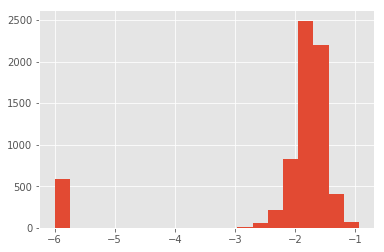

In [41]:
corr_df["IBL emphasis"].hist(bins=20)

In [36]:
corr = corr_df.corr(method='pearson')

In [37]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr = corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

corr

,% nonwhites (district),% poverty (district),% school closures last year (district),# students,% nonwhites students,school age,% poor students,# corporal punishment events preschool,# suspensions preschool,Discipline emphasis,IBL emphasis,# students expelled,absenteeism rate
% nonwhites (district),1,-0.49,-0.44,-0.13,-0.62,0.045,-0.29,0.029,-0.056,0.027,0.082,-0.067,-0.042
% poverty (district),-0.49,1,0.33,0.081,0.46,-0.04,0.34,0.021,0.063,-0.024,-0.089,0.07,0.022
% school closures last year (district),-0.44,0.33,1,0.036,0.029,-0.075,0.017,-0.011,-0.033,-0.12,-0.17,0.01,-0.0086
# students,-0.13,0.081,0.036,1,0.0024,0.14,0.0083,0.0085,0.0046,0.04,-0.0027,0.15,0.53
% nonwhites students,-0.62,0.46,0.029,0.0024,1,-0.04,0.45,0.0026,0.017,-0.011,-0.015,-0.0011,-0.016
school age,0.045,-0.04,-0.075,0.14,-0.04,1,0.01,0.024,0.062,0.033,0.02,0.0019,0.085
% poor students,-0.29,0.34,0.017,0.0083,0.45,0.01,1,0.0053,0.026,-0.018,-0.013,-0.0015,-0.0015
# corporal punishment events preschool,0.029,0.021,-0.011,0.0085,0.0026,0.024,0.0053,1,0.11,-0.013,-0.0034,0.0003,-0.0036
# suspensions preschool,-0.056,0.063,-0.033,0.0046,0.017,0.062,0.026,0.11,1,-0.016,0.0013,-0.12,-0.036
Discipline emphasis,0.027,-0.024,-0.12,0.04,-0.011,0.033,-0.018,-0.013,-0.016,1,0.58,0.0065,0.028


In [38]:
#fig = corr.gcf()
corr.savefig(dir_prefix + "Charter-school-identities/data/corrshade_100318.png")

AttributeError: 'Styler' object has no attribute 'savefig'

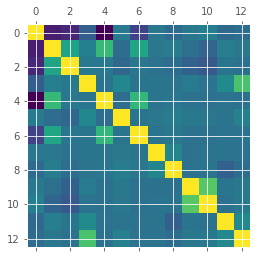

In [72]:
plt.matshow(corr_df.corr(method='pearson'))

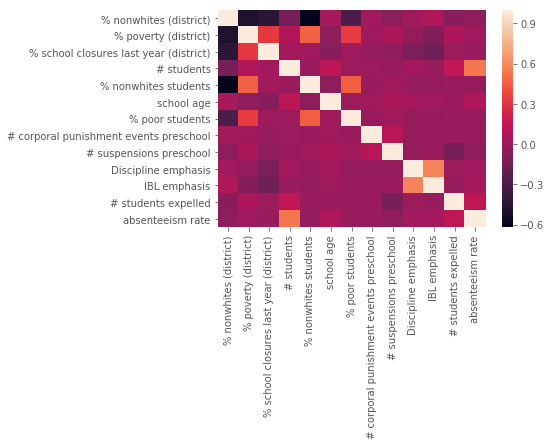

In [12]:
heatcorr = sns.heatmap(corr, 
                       xticklabels=corr.columns.values,
                       yticklabels=corr.columns.values)

heatcorr

In [18]:
fig = heatcorr.get_figure()
fig.savefig(dir_prefix + "Charter-school-identities/data/heatcorr_100318.png")

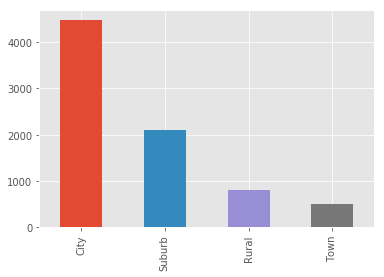

In [8]:
schooldf["PLACE"].value_counts().plot(kind='bar')
plt.show()

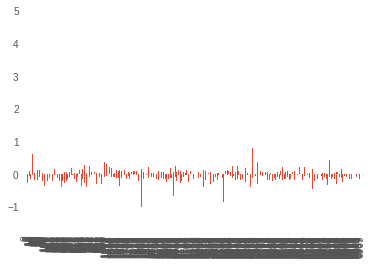

In [ ]:
grouped_place = schooldf.groupby("PLACE")
#grouped_locale.mean().sort_values(by="LOCALE",ascending=False)
grouped_place["IDLEAN"].median().plot(kind='bar')
plt.show()

In [21]:
corr_df = schooldf.drop(['YEAR_CLOSED', 'YEAR_OPENED', 'LATCODE', 'LONGCODE', 'ess_count', 'prog_count', 'rit_count', 'TOTETH', 'LEA_NAME', 'STATENAME', 'ADDRESS14', 'NCESSCH', 'LEAID'], axis=1)
print(corr_df.corr(method='spearman'))

                 TOTFRL    MEMBER    TITLEI       FTE  ess_strength  \
TOTFRL         1.000000  0.668498 -0.433346  0.583055      0.103058   
MEMBER         0.668498  1.000000 -0.090392  0.660596      0.073412   
TITLEI        -0.433346 -0.090392  1.000000 -0.105817     -0.039284   
FTE            0.583055  0.660596 -0.105817  1.000000      0.068535   
ess_strength   0.103058  0.073412 -0.039284  0.068535      1.000000   
prog_strength -0.128964 -0.054222  0.096320 -0.062019      0.065887   
AGE            0.103031  0.195928  0.003819  0.161897     -0.015991   
PCTETH         0.515593  0.137784 -0.403547  0.193420      0.097088   

               prog_strength       AGE    PCTETH  
TOTFRL             -0.128964  0.103031  0.515593  
MEMBER             -0.054222  0.195928  0.137784  
TITLEI              0.096320  0.003819 -0.403547  
FTE                -0.062019  0.161897  0.193420  
ess_strength        0.065887 -0.015991  0.097088  
prog_strength       1.000000 -0.011359 -0.147102  
AGE

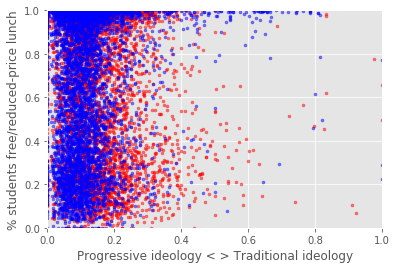

In [85]:
#plt.scatter(schooldf.IDLEAN, schooldf.PCTETH, alpha=0.5, c="purple", marker='.')
plt.scatter(schooldf.prog_strength, schooldf.PCTETH, alpha=0.5, c="red", marker='.') #s=schooldf.MEMBER # label="% students receiving FRPL by school ideology"
plt.scatter(schooldf.ess_strength, schooldf.PCTETH, alpha=0.5, c="blue", marker='.')

#plt.plot(schooldf.prog_strength, schooldf.PCTETH, c="red") #s=schooldf.MEMBER # label="% students receiving FRPL by school ideology"
#plt.plot(schooldf.ess_strength, schooldf.PCTETH, c="blue")

plt.ylim(0.0, 1.0) ; plt.ylabel("% students free/reduced-price lunch")
plt.xlim(0.0, 1.0) ; plt.xlabel("Progressive ideology < > Traditional ideology")

plt.show()

In [86]:
plt.plot(np.unique(schooldf.prog_strength), np.poly1d(np.polyfit(schooldf.prog_strength, schooldf.PCTETH, 1))(np.unique(schooldf.prog_strength)))

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [ ]:
sns.lmplot(x="prog_strength", y="PCTETH", data=schooldf)

In [ ]:
sns_plot = ...
sns_plot.savefig(dir_prefix + "Charter-school-identities/data/plot_output.png")